![PUBG_Logo](assets/PUBG_logo.png)

## Objective
* Employ Density-based spatial clustering of applications with noise (DBSCAN) algorithm on dataset.
* Discuss pertinent results.

## Background Information
* Playerunknown's Battleground (PUBG) is a video game, which set the standard for preceding games in the Battle Royale Genre. The main goal is to SURVIVE at all costs.

## Process:
* Exploratory Data Analysis conducted utilizing various python packages (Numpy, Matplotlib, Pandas, and Plotly).
* DBSCAN (Sci-Kit Learn)


## Table of Contents:
* Part I: Exploratory Data Analysis
    * EDA
* Part II: DBSCAN
    * DBSCAN

In [1]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

# PART I - Exploratory Data Analysis

### Data Preprocessing / Feature Engineering

Let us begin by reading in the CSV file containing the data, and examining the data contents such as the number of features and rows. It seems there are 152 column entries (features) and 87898 row entries (number of samples).

In [2]:
#--------- Pandas Dataframe
## Read in CSV
orig = pd.read_csv('data/PUBG_Player_Statistics.csv')

Now, let us remove and combine features, which do not pertain to our goal of clustering solo player behavior. 

Remove:
* player_name
* tracker_id
* duo
* squad

Add:
* Total Distance

This can be achieved by removing all columns after the 52nd. Also, create a new feature that combines the walking and riding distance.

Also, we will reduce the variance in the data by removing players with less than the mean number of rounds in our data.

In [3]:
#---------Preprocessing
## Create a copy of the dataframe
df = orig.copy()
cols = np.arange(52, 152, 1)

# Drop entries if they have null values
df.dropna(inplace = True)

## Drop columns after the 52nd index
df.drop(df.columns[cols], axis = 1, inplace = True)

## Drop player_name and tracker id
df.drop(df.columns[[0, 1]], axis = 1, inplace = True)

## Drop Knockout and Revives
df.drop(df.columns[[49]], axis = 1, inplace = True)
df.drop(columns = ['solo_Revives'], inplace = True)

## Drop the string solo from all strings
df.rename(columns = lambda x: x.lstrip('solo_').rstrip(''), inplace = True)

## Combine a few columns 
df['TotalDistance'] = df['WalkDistance'] + df['RideDistance']
df['AvgTotalDistance'] = df['AvgWalkDistance'] + df['AvgRideDistance']

# Remove Outliers
df = df.drop(df[df['RoundsPlayed'] < df['RoundsPlayed'].mean()].index)

Split the data into three sets: train, dev, and test set.

In [4]:
# Create train and test set using Sci-Kit Learn
train, test = train_test_split(df, test_size=0.3, random_state = 10)
dev, test = train_test_split(test, test_size = 0.2, random_state = 10)
data = train

print("The number of training samples is", len(train))
print("The number of development samples is", len(dev))
print("The number of testing samples is", len(test))

The number of training samples is 20771
The number of development samples is 7121
The number of testing samples is 1781


It is important we go through the final output to make sure that are data preprocessing is complete. And it looks great!

In [5]:
with pd.option_context('display.max_columns', 52):
    print(data.describe(include = 'all'))

       KillDeathRatio      WinRatio  TimeSurvived  RoundsPlayed          Wins  \
count    20771.000000  20771.000000  2.077100e+04  20771.000000  20771.000000   
mean         1.289158      2.204012  1.484172e+05    174.985894      3.554475   
std          0.602602      2.510500  9.339460e+04    113.147056      4.939222   
min          0.100000      0.000000  3.813548e+04     80.000000      0.000000   
25%          0.900000      0.680000  9.091498e+04    104.000000      1.000000   
50%          1.160000      1.460000  1.195404e+05    139.000000      2.000000   
75%          1.520000      2.910000  1.733681e+05    205.000000      4.000000   
max         17.410000     40.210000  1.219536e+06   1552.000000    102.000000   

       WinTop10Ratio        Top10s    Top10Ratio        Losses        Rating  \
count   20771.000000  20771.000000  20771.000000  20771.000000  20771.000000   
mean        0.138708     23.884743     14.369067    171.431419   2059.159131   
std         0.137145     19.21

The only factors above which have a positive correlation to average survival time are Average Total Distance, Win Ratio, and Top 10 Ratio.

# PART 2 - Clustering

Procedure: 
* 3D
* 2D

### Clustering in 3D (Selected Few Features)

We selected the following features because of experts and my domain experience playing PUBG.

In [6]:
# Select four features
train_data = train.loc[:,['WinRatio', 'KillDeathRatio', "HeadshotKillRatio", "Top10Ratio"]]
dev_data = dev.loc[:, ['WinRatio', 'KillDeathRatio', "HeadshotKillRatio", "Top10Ratio"]]
test_data = test.loc[:, ['WinRatio', 'KillDeathRatio', "HeadshotKillRatio", "Top10Ratio"]]

Feature scaling is utilized to make sure all features are normalized and have similar orders of magnitude. This is important because our clustering algorithms look into calculating the distance between points. In our case, we employed a zero-mean and unit-variance scaling.

In [7]:
# Scale the data (Normaliz)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(train_data)
X_dev_std = scaler.transform(dev_data)
X_test_std = scaler.transform(test_data)

#### DBSCAN


DBSCAN clustering is an algorithm, which groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions.

##### Algorithm
1. Arbitrarily select a point P.
2. Retrieve all points directly density-reachable from P with respect to ε.
3. If P is a core point, a cluster is formed. Find recursively all its density connected points and assign them to the same cluster as P.
4. If P is not a core point, DBSCAN iterates through the remaining unvisited points in the dataset.


##### Parameters

In DBSCAN, we'll be examining two parameters:
* minPoints: the minimum number of points to form a dense region.
* eps: specifies how close points should be to each other to be considered a part of a cluster. 

For minPoints, we will use a guideline in the original DBSCAN paper [1].

minPoints = 2*dimensions (number of features)

minPoints = 2 * 4 = 8

For eps, we will use a K-nearest-neighbors distance plot to identify the knee in the plot and select that distance [1].

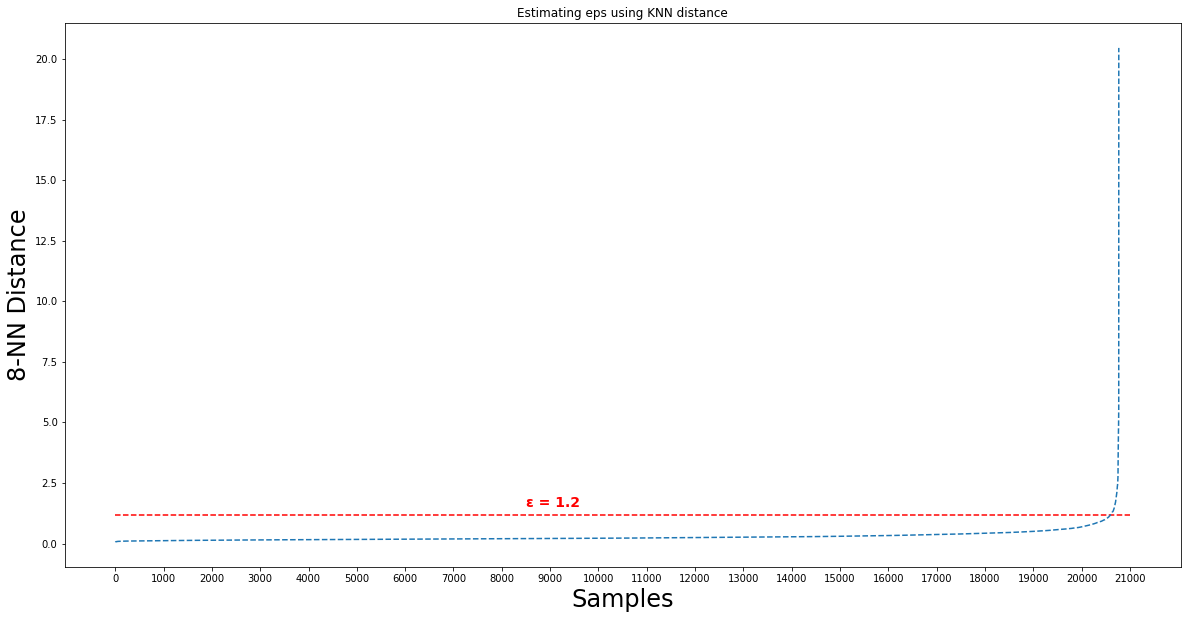

In [19]:
ns = 8
nbrs = NearestNeighbors(n_neighbors = ns).fit(X_train_std)
distances, indices = nbrs.kneighbors(X_train_std)
distanceDec = sorted(distances[:,ns-1], reverse = False)
plt.figure(figsize = (20, 10))
plt.plot(list(range(1, 20772)),
         distanceDec, '--')
plt.xticks(range(0, 22000, 1000))
plt.xlabel('Samples', fontsize = 24)
plt.ylabel('8-NN Distance', fontsize = 24)
plt.title('Estimating eps using KNN distance')

# Annotate Graph
plt.hlines(y = 1.2, color = 'red', linestyle = '--', xmin = 0, xmax = 21000)

plt.text(8500, 1.5 ,'ε = 1.2', size = 14, color = 'red', weight = 'semibold')

plt.show()

Begin with configuring all parameters for DBSCAN.

In [20]:
# DBSCAN on Training Data
dbscan = DBSCAN( eps = 1.2, min_samples = 8).fit(X_train_std)
labels = dbscan.labels_

Time:  8.850768899999991


Silhouette analysis studies how similar and dissimilar neighboring cluster centroids are. We select the point which is closest to +1. In our case, the parameters have a silhouette score of 0.7487.

In [17]:
ss = metrics.silhouette_score(X_train_std, dbscan.labels_)
print('The Silhouette Score for the training set is ' + str(ss) + ".")

The Silhouette Score for the training set is 0.7199005124529585.


Next, load in our function to plot our 3D scatter plots.

In [ ]:
def scatter3d_cluster(df, x, y, z, code, title):
    scatter = px.scatter_3d(df, x=x, y=y, z=z, color = code,  
                            color_discrete_sequence=px.colors.qualitative.Light24)
    
    scatter.update_layout(title = title, title_font = dict(size = 30),
                          scene = dict(
                              xaxis = dict(
                                  backgroundcolor="rgb(200, 200, 230)",
                                  gridcolor="white",
                                  showbackground=True,
                                  zerolinecolor="white",
                                  nticks=10, ticks='outside',
                                  tick0=0, tickwidth = 4,
                                  title_font = dict(size = 16)),
                              yaxis = dict(
                                  backgroundcolor="rgb(230, 200,230)",
                                  gridcolor="white",
                                  showbackground=True,
                                  zerolinecolor="white",
                                  nticks=10, ticks='outside',
                                  tick0=0, tickwidth = 4,
                                  title_font = dict(size = 16)),
                              zaxis = dict(
                                  backgroundcolor="rgb(230, 230,200)",
                                  gridcolor="white",
                                  showbackground=True,
                                  zerolinecolor="white",
                                  nticks=10, ticks='outside',
                                  tick0=0, tickwidth = 4,
                                  title_font = dict(size = 16),
                              ),
                          ),
                          width = 700
                         )
    return scatter.show()

Lastly, plot the data and let's label the data with our assumptions on how hackers are perceived.

Hackers tend to have high Kill-Death Ratios, Headshot-Kill Ratios, Top 10 Ratios, and Win Ratios.

In [ ]:
## 3D Plot of Training Data
# Create and modify dataframe for the cluster column
df_X_train_std = pd.DataFrame(X_train_std)
df_X_train_std['Cluster'] = pd.Series(labels, index = df_X_train_std.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Human", -1: "Hacker"}
df_X_train_std['Cluster_Labels'] = df_X_train_std['Cluster'].map(cluster_label_names)  

df_X_train_std.columns = ['Win Ratio', 'Kill Death Ratio', "Headshot Kill Ratio",
                          "Top 10 Ratio", 'Cluster', 'Cluster_Labels']

# Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = df_X_train_std , x = 'Kill Death Ratio',
                  y = 'Headshot Kill Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                  title = 'Clustering of Kill-Death Ratio, Headshot-Kill Ratio, and Win Ratio')

scatter3d_cluster(df = df_X_train_std , x = 'Kill Death Ratio', 
                  y = 'Top 10 Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                  title = 'Clustering of Kill-Death Ratio, Top 10 Ratio, and Win Ratio')

scatter3d_cluster(df = df_X_train_std , x = 'Headshot Kill Ratio',
                  y = 'Top 10 Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                 title = 'Clustering of Headshot-Kill Ratio, Top 10 Ratio, and Win Ratio') 


In [ ]:
df_X_train_std['Cluster'].value_counts()

From the plots, we observed roughly 20689 humans and 82 hackers. With my previous assumption of hackers being a small portion of the population (0 - 10%), their behavior can be analogous to an outlier. Therefore, maybe an outlier detection algorithm (anomaly detection) is a viable solution to this problem. 

In [ ]:
df_X_train_std.groupby('Cluster_Labels').count()

##### Predicting on the dev set

Begin with predicting on the dev set.

In [9]:
def dbscan_predict(model, X):
    "Predict function created for DBSCAN"
    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [14]:
predict_labels = dbscan_predict(dbscan, X_dev_std)

Next, create the 3D scatter plots.

In [ ]:
## 3D Plot of deving Data
# Create and modify dataframe for the cluster column
df_X_dev_std = pd.DataFrame(X_dev_std)
df_X_dev_std['Cluster'] = pd.Series(predict_labels, index=df_X_dev_std.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Human", -1: "Hacker"}
df_X_dev_std['Cluster_Labels'] = df_X_dev_std['Cluster'].map(cluster_label_names)  

df_X_dev_std.columns = ['Win Ratio', 'Kill Death Ratio', "Headshot Kill Ratio",
                          "Top 10 Ratio", 'Cluster', 'Cluster_Labels']

# Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = df_X_dev_std , x = 'Kill Death Ratio',
                  y = 'Headshot Kill Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                  title = 'Clustering of Kill-Death Ratio, Headshot-Kill Ratio, and Win Ratio' )

scatter3d_cluster(df = df_X_dev_std , x = 'Kill Death Ratio', 
                  y = 'Top 10 Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                  title = 'Clustering of Kill-Death Ratio, Top 10 Ratio, and Win Ratio')

scatter3d_cluster(df = df_X_dev_std , x = 'Headshot Kill Ratio',
                  y = 'Top 10 Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                 title = 'Clustering of Headshot-Kill Ratio, Top 10 Ratio, and Win Ratio') 

From the plots, we observed roughly 7040 humans and 83 hackers.

In [ ]:
df_X_dev_std.groupby('Cluster_Labels').count()

##### Predicting on the test set

Begin with predicting on the test set.

In [ ]:
# DBSCAN on test data
predict_labels = dbscan_predict(dbscan, X_test_std)

Next, create the 3D scatter plots.

In [ ]:
## 3D Plot of testing Data
# Create and modify dataframe for the cluster column
df_X_test_std = pd.DataFrame(X_test_std)
df_X_test_std['Cluster'] = pd.Series(predict_labels, index = df_X_test_std.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Human", -1: "Hacker"}
df_X_test_std['Cluster_Labels'] = df_X_test_std['Cluster'].map(cluster_label_names)  

df_X_test_std.columns = ['Win Ratio', 'Kill Death Ratio', "Headshot Kill Ratio",
                          "Top 10 Ratio", 'Cluster', 'Cluster_Labels']

# Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = df_X_test_std , x = 'Kill Death Ratio',
                  y = 'Headshot Kill Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                  title = 'Clustering of Kill-Death Ratio, Headshot-Kill Ratio, and Win Ratio')

scatter3d_cluster(df = df_X_test_std , x = 'Kill Death Ratio', 
                  y = 'Top 10 Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                  title = 'Clustering of Kill-Death Ratio, Top 10 Ratio, and Win Ratio')

scatter3d_cluster(df = df_X_test_std , x = 'Headshot Kill Ratio',
                  y = 'Top 10 Ratio', z = 'Win Ratio', code = 'Cluster_Labels', 
                 title = 'Clustering of Headshot-Kill Ratio, Top 10 Ratio, and Win Ratio') 

From the plots, we observed roughly 1773 humans and 8 hackers.

In [ ]:
df_X_test_std.groupby('Cluster_Labels').count()

### Clustering in 2D (Selected Few Features)

Let's examine all of these clusters in two-dimensions to see any patterns.

Begin with configuring all parameters for DBSCAN.

In [ ]:
# DBSCAN on Training Data
dbscan = DBSCAN( eps = 1.2, min_samples = 8).fit(X_train_std)
labels = dbscan.labels_

Next, we'll use the function below to create our 2D scatter plots.

In [ ]:
def scatter2d_cluster(df, x, y,  code, title):
    scatter = px.scatter(df, x = x, y = y, color = code,
                         color_discrete_sequence = px.colors.qualitative.Light24)
    
    scatter.update_xaxes(showline = True, linewidth = 1, linecolor = 'black', 
                          mirror = True, gridcolor = 'LightPink', automargin = True, 
                          zeroline = True, zerolinewidth = 2, zerolinecolor = 'LightPink', 
                          ticks = "outside", tickwidth = 2, tickcolor = 'black', ticklen = 10,
                          title_font = dict(size = 18))
    scatter.update_yaxes(showline = True, linewidth = 2, linecolor = 'black', 
                          mirror = True, gridcolor = 'LightPink',
                          zeroline = True, zerolinewidth = 1, zerolinecolor = 'LightPink', 
                          ticks = "outside", tickwidth = 2, tickcolor = 'black', ticklen = 10,
                          title_font = dict(size = 18))
    
    
    scatter.update_layout(title = title, title_font = dict(size = 24), 
                          legend = dict(
                              x = 1,
                              y = 1,
                              traceorder = "normal",
                              font = dict(
                                  family = "sans-serif",
                                  size = 14,
                                  color = "black"
                              ),
                              bgcolor = "#e5ecf6",
                              bordercolor = "Black",
                              borderwidth = 2
                          )
                         )
    return scatter.show()


Finally, we'll populate our scatter plots.

In [ ]:
## 2D Plot of Training Data
# Create and modify dataframe for the cluster column
df_X_train_std = pd.DataFrame(X_train_std)
df_X_train_std['cluster'] = pd.Series(labels, index = df_X_train_std.index)
df_X_train_std.columns = ['Win Ratio', 'Kill Death Ratio', "Headshot Kill Ratio", "Top 10 Ratio", 'cluster']

#Rename Cluster label names from k-means
cluster_label_names = {0: "Human", -1: "Hacker"}
df_X_train_std['Cluster_Labels'] = df_X_train_std['cluster'].map(cluster_label_names)  


# Plots of Win Ratio, KDR, Headshott KIll Ratio
scatter2d_cluster(df = df_X_train_std , x = 'Kill Death Ratio',
                  y = 'Win Ratio',  code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Win Ratio')

scatter2d_cluster(df = df_X_train_std , x = 'Kill Death Ratio',
                  y = 'Headshot Kill Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Headshot Kill Ratio')

scatter2d_cluster(df = df_X_train_std , x = 'Headshot Kill Ratio',
                  y = 'Win Ratio',  code = 'Cluster_Labels',
                  title = 'Clustering of Headshot Kill Ratio and Win Ratio')

scatter2d_cluster(df = df_X_train_std , x = 'Kill Death Ratio',
                  y = 'Top 10 Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Top 10 Ratio')

scatter2d_cluster(df = df_X_train_std , x = 'Headshot Kill Ratio',
                  y = 'Top 10 Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Headshot Kill Ratio and Top 10 Ratio')


From the plots, we observed roughly 20689 humans and 82 hackers.

In [ ]:
df_X_train_std.groupby('Cluster_Labels').count()

##### Predicting on the dev set

Begin with predicting on the dev set.

In [ ]:
# DBSCAN on dev set
predict_labels = dbscan_predict(dbscan, X_dev_std)

Next, populate our 2D scatter plots.

In [ ]:
## 3D Plot of Testing Data
# Create and modify dataframe for the cluster column
df_X_dev_std = pd.DataFrame(X_dev_std)
df_X_dev_std['cluster'] = pd.Series(predict_labels, index=df_X_dev_std.index)
df_X_dev_std.columns = ['Win Ratio', 'Kill Death Ratio', "Headshot Kill Ratio", "Top 10 Ratio", 'cluster']

#Rename Cluster label names from k-means
cluster_label_names = {0: "Human", -1: "Hacker"}
df_X_dev_std['Cluster_Labels'] = df_X_dev_std['cluster'].map(cluster_label_names)  


# Plots of Win Ratio, KDR, Headshott KIll Ratio
scatter2d_cluster(df = df_X_dev_std , x = 'Kill Death Ratio',
                  y = 'Win Ratio',  code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Win Ratio')

scatter2d_cluster(df = df_X_dev_std , x = 'Kill Death Ratio',
                  y = 'Headshot Kill Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Headshot Kill Ratio')

scatter2d_cluster(df = df_X_dev_std , x = 'Headshot Kill Ratio',
                  y = 'Win Ratio',  code = 'Cluster_Labels',
                  title = 'Clustering of Headshot Kill Ratio and Win Ratio')

scatter2d_cluster(df = df_X_dev_std , x = 'Kill Death Ratio',
                  y = 'Top 10 Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Top 10 Ratio')

scatter2d_cluster(df = df_X_dev_std , x = 'Headshot Kill Ratio',
                  y = 'Top 10 Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Headshot Kill Ratio and Top 10 Ratio')

From the plots, we observed roughly 7088 humans and 33 hackers.

In [ ]:
df_X_dev_std.groupby('Cluster_Labels').count()

##### Predicting on the test set

Begin with predicting on the test set.

In [ ]:
# DBSCAN on test set
predict_labels = dbscan_predict(dbscan, X_test_std)

Next, populate our 2D scatter plots.

In [ ]:
## 3D Plot of Testing Data
# Create and modify dataframe for the cluster column
df_X_test_std = pd.DataFrame(X_test_std)
df_X_test_std['cluster'] = pd.Series(predict_labels, index=df_X_test_std.index)
df_X_test_std.columns = ['Win Ratio', 'Kill Death Ratio', "Headshot Kill Ratio", "Top 10 Ratio", 'cluster']

#Rename Cluster label names from k-means
cluster_label_names = {0: "Human", -1: "Hacker"}
df_X_test_std['Cluster_Labels'] = df_X_test_std['cluster'].map(cluster_label_names)  


# Plots of Win Ratio, KDR, Headshott KIll Ratio
scatter2d_cluster(df = df_X_test_std , x = 'Kill Death Ratio',
                  y = 'Win Ratio',  code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Win Ratio')

scatter2d_cluster(df = df_X_test_std , x = 'Kill Death Ratio',
                  y = 'Headshot Kill Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Headshot Kill Ratio')

scatter2d_cluster(df = df_X_test_std , x = 'Headshot Kill Ratio',
                  y = 'Win Ratio',  code = 'Cluster_Labels',
                  title = 'Clustering of Headshot Kill Ratio and Win Ratio')

scatter2d_cluster(df = df_X_test_std , x = 'Kill Death Ratio',
                  y = 'Top 10 Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Kill Death Ratio and Top 10 Ratio')

scatter2d_cluster(df = df_X_test_std , x = 'Headshot Kill Ratio',
                  y = 'Top 10 Ratio', code = 'Cluster_Labels',
                  title = 'Clustering of Headshot Kill Ratio and Top 10 Ratio')

From the plots, we observed roughly 1773 humans and 8 hackers.

In [ ]:
df_X_test_std.groupby('Cluster_Labels').count()

### Remarks
* Without external labels, we cannot verify the accuracy of these clusters. But we can make an educated guess on what these clusters are by using domain experience and advice from experts playing the game.
* Treating this problem as an outlier detection (anomaly detection) problem has yielded promising results.
    * With the assumption that the number of hackers in our population is low, we can treat them as outliers.
* However, most of the outliers in our models can be misclassifying actual humans, so further tuning needs to be done to reduce that misclassification rate.
* Possible tunings are:
    * Hyperparameter grid search to identify best parameters that reduce our misclassification rate.
    * Using different distance metrics to cluster our data.
    * Dimensional reduction techniques because DBSCAN does not perform well with a high number of features.
    * Additional anomaly detection algorithms.

### References

[1] Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. ACM Transactions on Database Systems (TODS), 42(3), 19.